# Pneumonia Detection 


### Importing libraries

In [38]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory as idf

Defining the path of dataset images and the paths of train, test and validation respectively

In [21]:
dir_path = "./archive/chest_xray/"

In [23]:
''' training path '''
train_p = os.path.join(dir_path, "train")

''' test path '''
test_p =os.path.join(dir_path, "test")

''' val path '''
val_p = os.path.join(dir_path, "val")

In [24]:
''' PNEUMONIA images '''
p_train_images = glob.glob(train_p + "/PNEUMONIA/*.jpeg")

''' NORMAL  images '''
n_train_images = glob.glob(train_p + "/NORMAL/*.jpeg")

In [25]:
df = pd.DataFrame(np.concatenate([[0]*len(n_train_images) , [1] *  len(p_train_images)]),columns=["class"])

<AxesSubplot:ylabel='count'>

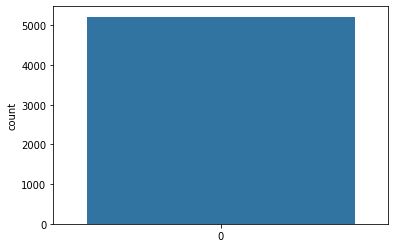

In [26]:
sns.countplot(df['class'])

Data Augmentation

In [53]:
''' Data Augmentation '''
train_datagen = ImageDataGenerator(rescale =1/255, shear_range=10, zoom_range = 0.2, horizontal_flip = True, 
                              width_shift_range=0.2, fill_mode = 'nearest')

test_datagen=ImageDataGenerator(
    rescale = 1/255
)

val_datagen = ImageDataGenerator(
    rescale = 1/255
)

VGG16 Model (Pre trained Convolutional Neural network)
Training disabled for the VGG16 weights

In [28]:
''' VGG16 Model '''

model1 = VGG16(include_top = False,weights='imagenet')

''' freezing layers '''
for i in model1.layers:
    i.trainable=False
    
out = model1.output

''' GlobalAveragePooling Layer '''
out = keras.layers.GlobalAveragePooling2D()(out)
out = keras.layers.Dense(128, activation='relu')(out)

''' Classification Layer '''
pred = keras.layers.Dense(1, activation='sigmoid')(out)

''' final model '''
model= keras.Model(model1.input, pred)

lr = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000, decay_rate=0.96, staircase=True)

''' Compile the model '''
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr_schedule), metrics=['accuracy'])

Model Structure :

In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

Creating train, test and validation dataset

In [55]:

train_ds = train_datagen.flow_from_directory(train_p, target_size=(150,150), batch_size= 16, class_mode='binary')

val_ds = val_datagen.flow_from_directory(val_p, target_size=(150,150),batch_size=8, class_mode='binary')

tes_ds = test_datagen.flow_from_directory(test_p, target_size=(150,150), batch_size=32, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Training : 

In [56]:
history = model.fit(train_ds, steps_per_epoch = 100, epochs=20, validation_data=val_ds)

Epoch 1/20
100/100 [==============================] - 46s 366ms/step - loss: 2.5330 - accuracy: 0.7600 - val_loss: 0.2569 - val_accuracy: 0.8750
Epoch 2/20
100/100 [==============================] - 34s 340ms/step - loss: 0.3813 - accuracy: 0.8525 - val_loss: 0.2684 - val_accuracy: 0.8750
Epoch 3/20
100/100 [==============================] - 35s 345ms/step - loss: 0.4321 - accuracy: 0.8606 - val_loss: 0.4768 - val_accuracy: 0.8125
Epoch 4/20
100/100 [==============================] - 37s 370ms/step - loss: 0.3083 - accuracy: 0.8831 - val_loss: 0.6388 - val_accuracy: 0.8125
Epoch 5/20
100/100 [==============================] - 38s 383ms/step - loss: 0.2953 - accuracy: 0.8875 - val_loss: 0.2552 - val_accuracy: 0.8750
Epoch 6/20
100/100 [==============================] - 42s 414ms/step - loss: 0.3484 - accuracy: 0.8819 - val_loss: 0.6504 - val_accuracy: 0.7500
Epoch 7/20
100/100 [==============================] - 44s 439ms/step - loss: 0.3105 - accuracy: 0.9031 - val_loss: 0.4611 - val_ac

In [64]:
accuracy = model.evaluate_generator(tes_ds,624)[1]
print("Accuracy of the model is : ",accuracy)

c:\Users\KIIT\.conda\envs\tensorflow\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Accuracy of the model is :  0.9294871687889099


Accuracy of the model is :  0.879807710647583


Training with the weights of VGG16 allowed to train

In [61]:
for layer in model1.layers:
    layer.trainable = True

In [62]:
lr = 1e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000, decay_rate=0.96, staircase=True)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr_schedule), loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [63]:
model.fit(train_ds, steps_per_epoch = 50, epochs=100, validation_data=val_ds)

Epoch 1/100


c:\Users\KIIT\.conda\envs\tensorflow\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


50/50 [==============================] - 35s 590ms/step - loss: 0.3653 - binary_accuracy: 0.9125 - val_loss: 0.2391 - val_binary_accuracy: 0.9375
Epoch 2/100
50/50 [==============================] - 30s 587ms/step - loss: 0.2761 - binary_accuracy: 0.8875 - val_loss: 0.2202 - val_binary_accuracy: 0.9375
Epoch 3/100
50/50 [==============================] - 30s 587ms/step - loss: 0.2340 - binary_accuracy: 0.9087 - val_loss: 0.9417 - val_binary_accuracy: 0.7500
Epoch 4/100
50/50 [==============================] - 30s 603ms/step - loss: 0.2149 - binary_accuracy: 0.9250 - val_loss: 0.3463 - val_binary_accuracy: 0.8750
Epoch 5/100
50/50 [==============================] - 50s 1s/step - loss: 0.1771 - binary_accuracy: 0.9450 - val_loss: 0.1716 - val_binary_accuracy: 0.9375
Epoch 6/100
50/50 [==============================] - 57s 1s/step - loss: 0.1794 - binary_accuracy: 0.9300 - val_loss: 0.6858 - val_binary_accuracy: 0.8125
Epoch 7/100
50/50 [==============================] - 65s 1s/step - los

In [66]:
''' evaluating model '''
final_acc = model.evaluate_generator(tes_ds,624)[1]

c:\Users\KIIT\.conda\envs\tensorflow\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [67]:
final_acc

0.9294871687889099

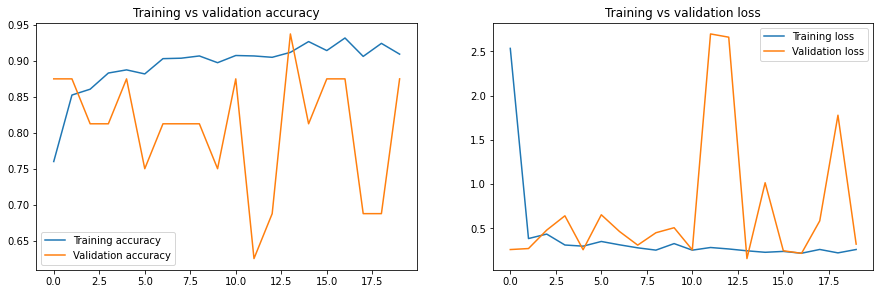

In [65]:
''' Training Accuracy and Validaion Accuracy graph '''
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label = "Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

''' Training Loss and Validation Loss graph '''
plt.subplot(2,2,2)
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()